## **Introduction**

This notebook demonstrates how to use BERT for toxic content detection and leverage LIME (Local Interpretable Model-Agnostic Explanations) to explain the predictions made by the BERT model. We will walk through the process of classifying toxic content in text using a pre-trained BERT model and then visualize which words contributed the most to the model's decision using LIME.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Ly3ZATeNtOTvHYX2T8kUN2U8QFTgDFBM?usp=sharing)


Author: Lennox Anderson

Date Modified: September 29th, 2024.

---

## **Dependencies**

In [1]:
# installs the Hugging Face Transformers library, needed for loading BERT models and tokenizers
!pip install transformers
# installs the LIME library used for explaining model predictions by perturbing the input data
!pip install lime
# installs matplotlib for plotting and visualizing
!pip install matplotlib
# handle arrays and numeric operations
!pip install numpy
# LIME uses IPython.display for rendering visualizations in a Jupyter notebook
!pip install ipython

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import lime
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import warnings
from IPython.display import Image, display

---

## **Section 1: Toxic Content Detection using BERT**

In this section, we load a pre-trained BERT model that is fine-tuned for toxic content detection. The BERT model will predict categories such as toxic, severe toxic, obscene, threat, insult, and identity hate based on the input text.

         +---------------------------+
         |  Input Text                |
         | "You are a terrible person"|
         +---------------------------+
                     |
                     v
         +---------------------------+
         |  Tokenization with BERT    |   <--- BERT's tokenizer converts the text into
         |  [CLS] You are a terrible  |        tokens that the model can understand.
         |  person [SEP]              |
         +---------------------------+
                     |
                     v
         +-----------------------------------+
         | Pass Tokens to BERT Model         |   <--- The tokenized text is passed into the
         |                                   |        pre-trained BERT model for classification.
         |  BERT processes tokens and        |
         |  generates hidden representations |
         +-----------------------------------+
                     |
                     v
         +-----------------------------------+
         |  BERT Classifier Head             |   <--- The final layer of BERT produces raw scores
         |                                   |        (logits) for each class based on its
         |  Outputs logits for toxic classes:|        understanding of the text.
         |  [toxic, severe toxic, obscene,   |
         |   threat, insult, identity hate]  |
         +-----------------------------------+
                     |
                     v
         +-----------------------------------+
         | Softmax Applied to Logits         |   <--- The logits (raw scores) are passed
         |                                   |        through the softmax function to
         |  Toxic: 0.75                      |        get probabilities for each class.
         |  Severe Toxic: 0.05               |        (The sum of probabilities = 1)
         |  Obscene: 0.15                    |
         |  Threat: 0.01                     |
         |  Insult: 0.04                     |
         |  Identity Hate: 0.00              |
         +-----------------------------------+
                     |
                     v
         +---------------------------+
         |  Final Prediction:         |
         |  "Toxic"                   |   <--- The class with the highest probability
         +---------------------------+        is the predicted label.


In [6]:
text = "You are a terrible person"

In [7]:
# handle warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# initialize BERT model toxcity detection and tokenizing
model_name = "unitary/toxic-bert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

# tokenize and convert to tensors
# we convert the tokenizer output to tensors because tensors are the format BERT requires for processing
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

# speed up the process since gradients are not needed for making predictions
# pass the tokenized tensors to BERT to generate predictions
# Extracts the raw, unnormalized output scores (logits) from the model.
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# apply softmax
# softmax: a mathematical function that converts raw scores (logits) into probabilities, ensuring that the sum of the probabilities is 1
probabilities = torch.softmax(logits, dim=-1).numpy()

# labels from BERT
class_names = ['toxic', 'severe toxic', 'obscene', 'threat', 'insult', 'identity hate']

predicted_class = class_names[probabilities.argmax()]
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probabilities}")

Predicted class: toxic
Class probabilities: [[8.8851833e-01 1.9258070e-04 2.6736790e-03 1.4136694e-04 1.0810062e-01
  3.7333742e-04]]


**Output:** `Class probabilities: [[8.8851833e-01 1.9258070e-04 2.6736790e-03 1.4136694e-04 1.0810062e-01
  3.7333742e-04]]`

The above output shows the model's confidence in each class, with 73.76% probability for "toxic." While helpful, it doesn't explain why the model made this decision. It lacks transparency in identifying which words influenced the prediction. Tools like LIME or SHAP can enhance explainability by highlighting key features that contributed to the model's output.


---

## **Section 2: Explaining Model Predictions with LIME**

LIME helps make model predictions interpretable by showing which parts of the text (words or phrases) contributed most to the final classification. In this section, we use LIME to generate an explanation for the BERT model's toxic content prediction.

         +-----------------------------+
         |  Input Text:                |
         |  "You are a terrible person"|
         +-----------------------------+
                     |
                     v
         +--------------------------------------+
         | BERT Tokenization                    |   <--- BERT tokenizes the text
         | [CLS] You are a terrible person[SEP] |
         +--------------------------------------+
                     |
                     v
         +--------------------------------------+
         | LIME Perturbs the Text               |   <--- LIME generates variations of the
         | "You are a terrible"                 |        original text by removing or changing
         | "You are a person"                   |        certain words for each perturbation.
         | "terrible person"                    |
         +--------------------------------------+
                     |
                     v
         +-------------------------------------------------------+
         | Pass Perturbations to BERT                            |   <--- Each perturbed version of the text
         |                                                       |        is passed to the BERT model.
         | BERT processes the input tokens and                   |        The model outputs logits (raw scores)
         | generates logits for each toxicity                    |        for each class.
         | class:                                                |
         |                                                       |
         | Perturbed Text: "You are a terrible"                  |
         |  Logits -> [toxic: 0.65, insult: 0.25, neutral: 0.10] |
         |                                                       |
         | Perturbed Text: "terribible person"                   |
         |  Logits -> [toxic: 0.85, insult: 0.75, neutral: 0.05] |
         +-------------------------------------------------------+
                     |
                     v
         +-----------------------------------------------+
         | LIME Analyzes Feature Importance              |   <--- LIME observes how removing or altering
         |                                               |        specific words affects BERT's predictions.
         |                                               |        It determines which words are critical
         |                                               |        to the prediction.
         |                                               |
         | "terrible" -> heavily increases toxicity score|
         | "You" -> lowers toxicity, neutral impact      |
         | "are" -> minor impact                         |
         +-----------------------------------------------+
                     |
                     v
         +--------------------------------------+
         | Final LIME Explanation:              |
         |                                      |
         | "terrible" -> +0.70 Toxicity         |   <--- LIME highlights the words that had the
         | "You" -> -0.15 Neutral               |        most influence on the toxic content
         | "are a" -> +0.05 Neutral             |        classification.
         +--------------------------------------+


In [12]:
text = "You are a terrible person"

In [13]:
# initialize BERT model for toxicity detection and tokenizing
model_name = "unitary/toxic-bert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

# BERTs labels
class_names = ['toxic', 'severe toxic', 'obscene', 'threat', 'insult', 'identity hate']

inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1).numpy()

# initialize LIME text explainer
explainer = LimeTextExplainer(class_names=class_names)

# perturbs the text for LIME analysis.
# gets model probabilities using softmax.
# highlights important words affecting predictions.
explanation = explainer.explain_instance(text, lambda x: torch.softmax(model(**tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=512)).logits, dim=-1).detach().numpy(), num_features=10)

# show bar chart explanation
explanation.show_in_notebook(text=True)

The code utilizes a pre-trained BERT model to classify text as toxic, generating probabilities for categories like toxic, insult, and others. LIME is used to explain the model's prediction by highlighting which words in the input text contributed most to the classification, with the phrase "You are a terrible person" being identified as the key driver for the high toxic score. This approach provides transparency by showing how specific words influence the model's decision.


### Feature Weights

In [16]:
# raw explaination
explanation_list = explanation.as_list()
for feature, weight in explanation_list:
    print(f"Feature: {feature}, Weight: {weight}")

Feature: terrible, Weight: -0.00872103278879751
Feature: You, Weight: -0.00852305714218156
Feature: are, Weight: -0.006707367073667865
Feature: a, Weight: -0.0023461900341650425
Feature: person, Weight: -0.002103425728645788


This LIME output shows that the words "terrible," "You," "are," "a," and "person" contributed to the model's prediction with negative weights, meaning that these words influenced the model toward a certain classification (likely "toxic" in this case) but with relatively small impact due to their low weights. The more negative the weight, the stronger the word's contribution to the decision.

---

## Section 3: Explainability Present and Absent in a Web Application Discussion

Being able to explain how black-box models work is crucial for building trust in AI systems. It's important to explore how this trust can extend to other applications, demonstrating how explainability can enhance a variety of use cases.

For example, the following music app utilizes a DistilBERT model—an efficient variant of BERT—to detect toxicity in song lyrics, similar to the model used in the earlier example. While the app successfully provides toxicity levels, incorporating explainability methods like LIME would add significant value by revealing why the model made certain decisions, offering deeper insights into how it interprets toxicity in lyrics.

https://lennoxanderson.com/musicapp

### Page 1: Select "Song Toxcity Analysis"

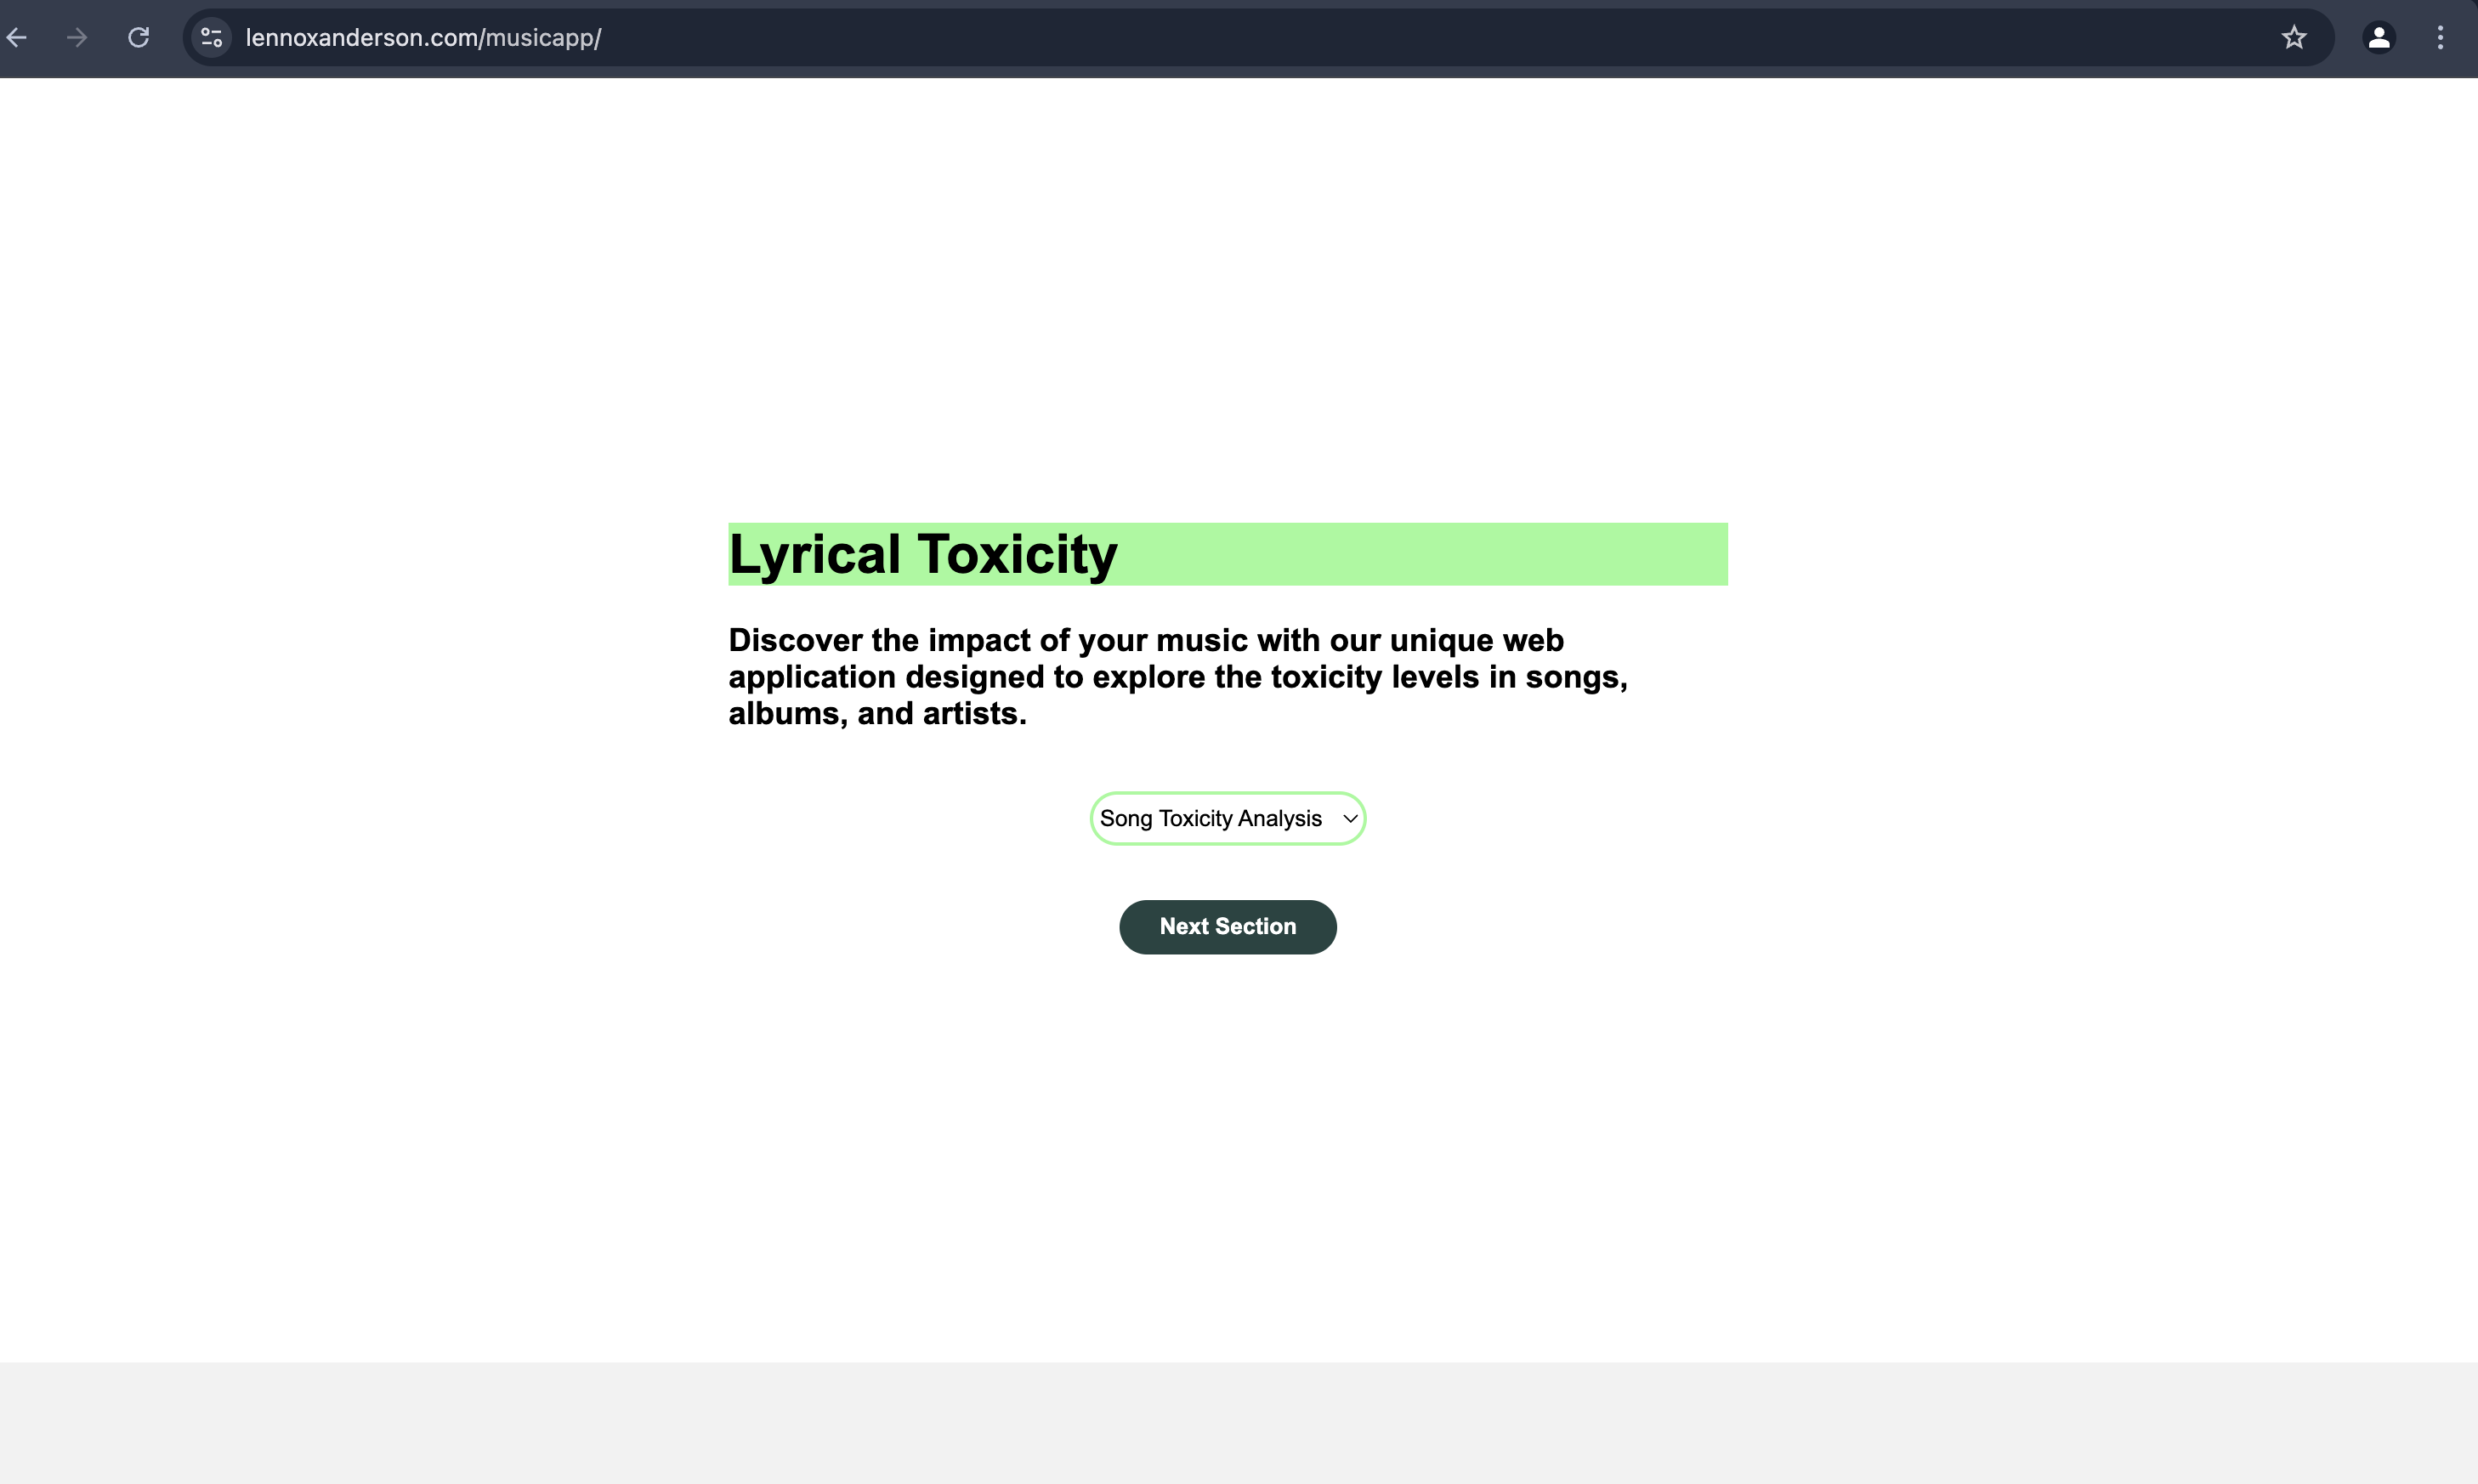

In [21]:
image_path = "/Users/lennox/Documents/machineLearning/research/modelAnalysis/page1MusicApp.png"
display(Image(filename=image_path, width=900, height=600))

### Page 2: Insert "Song & Artist"

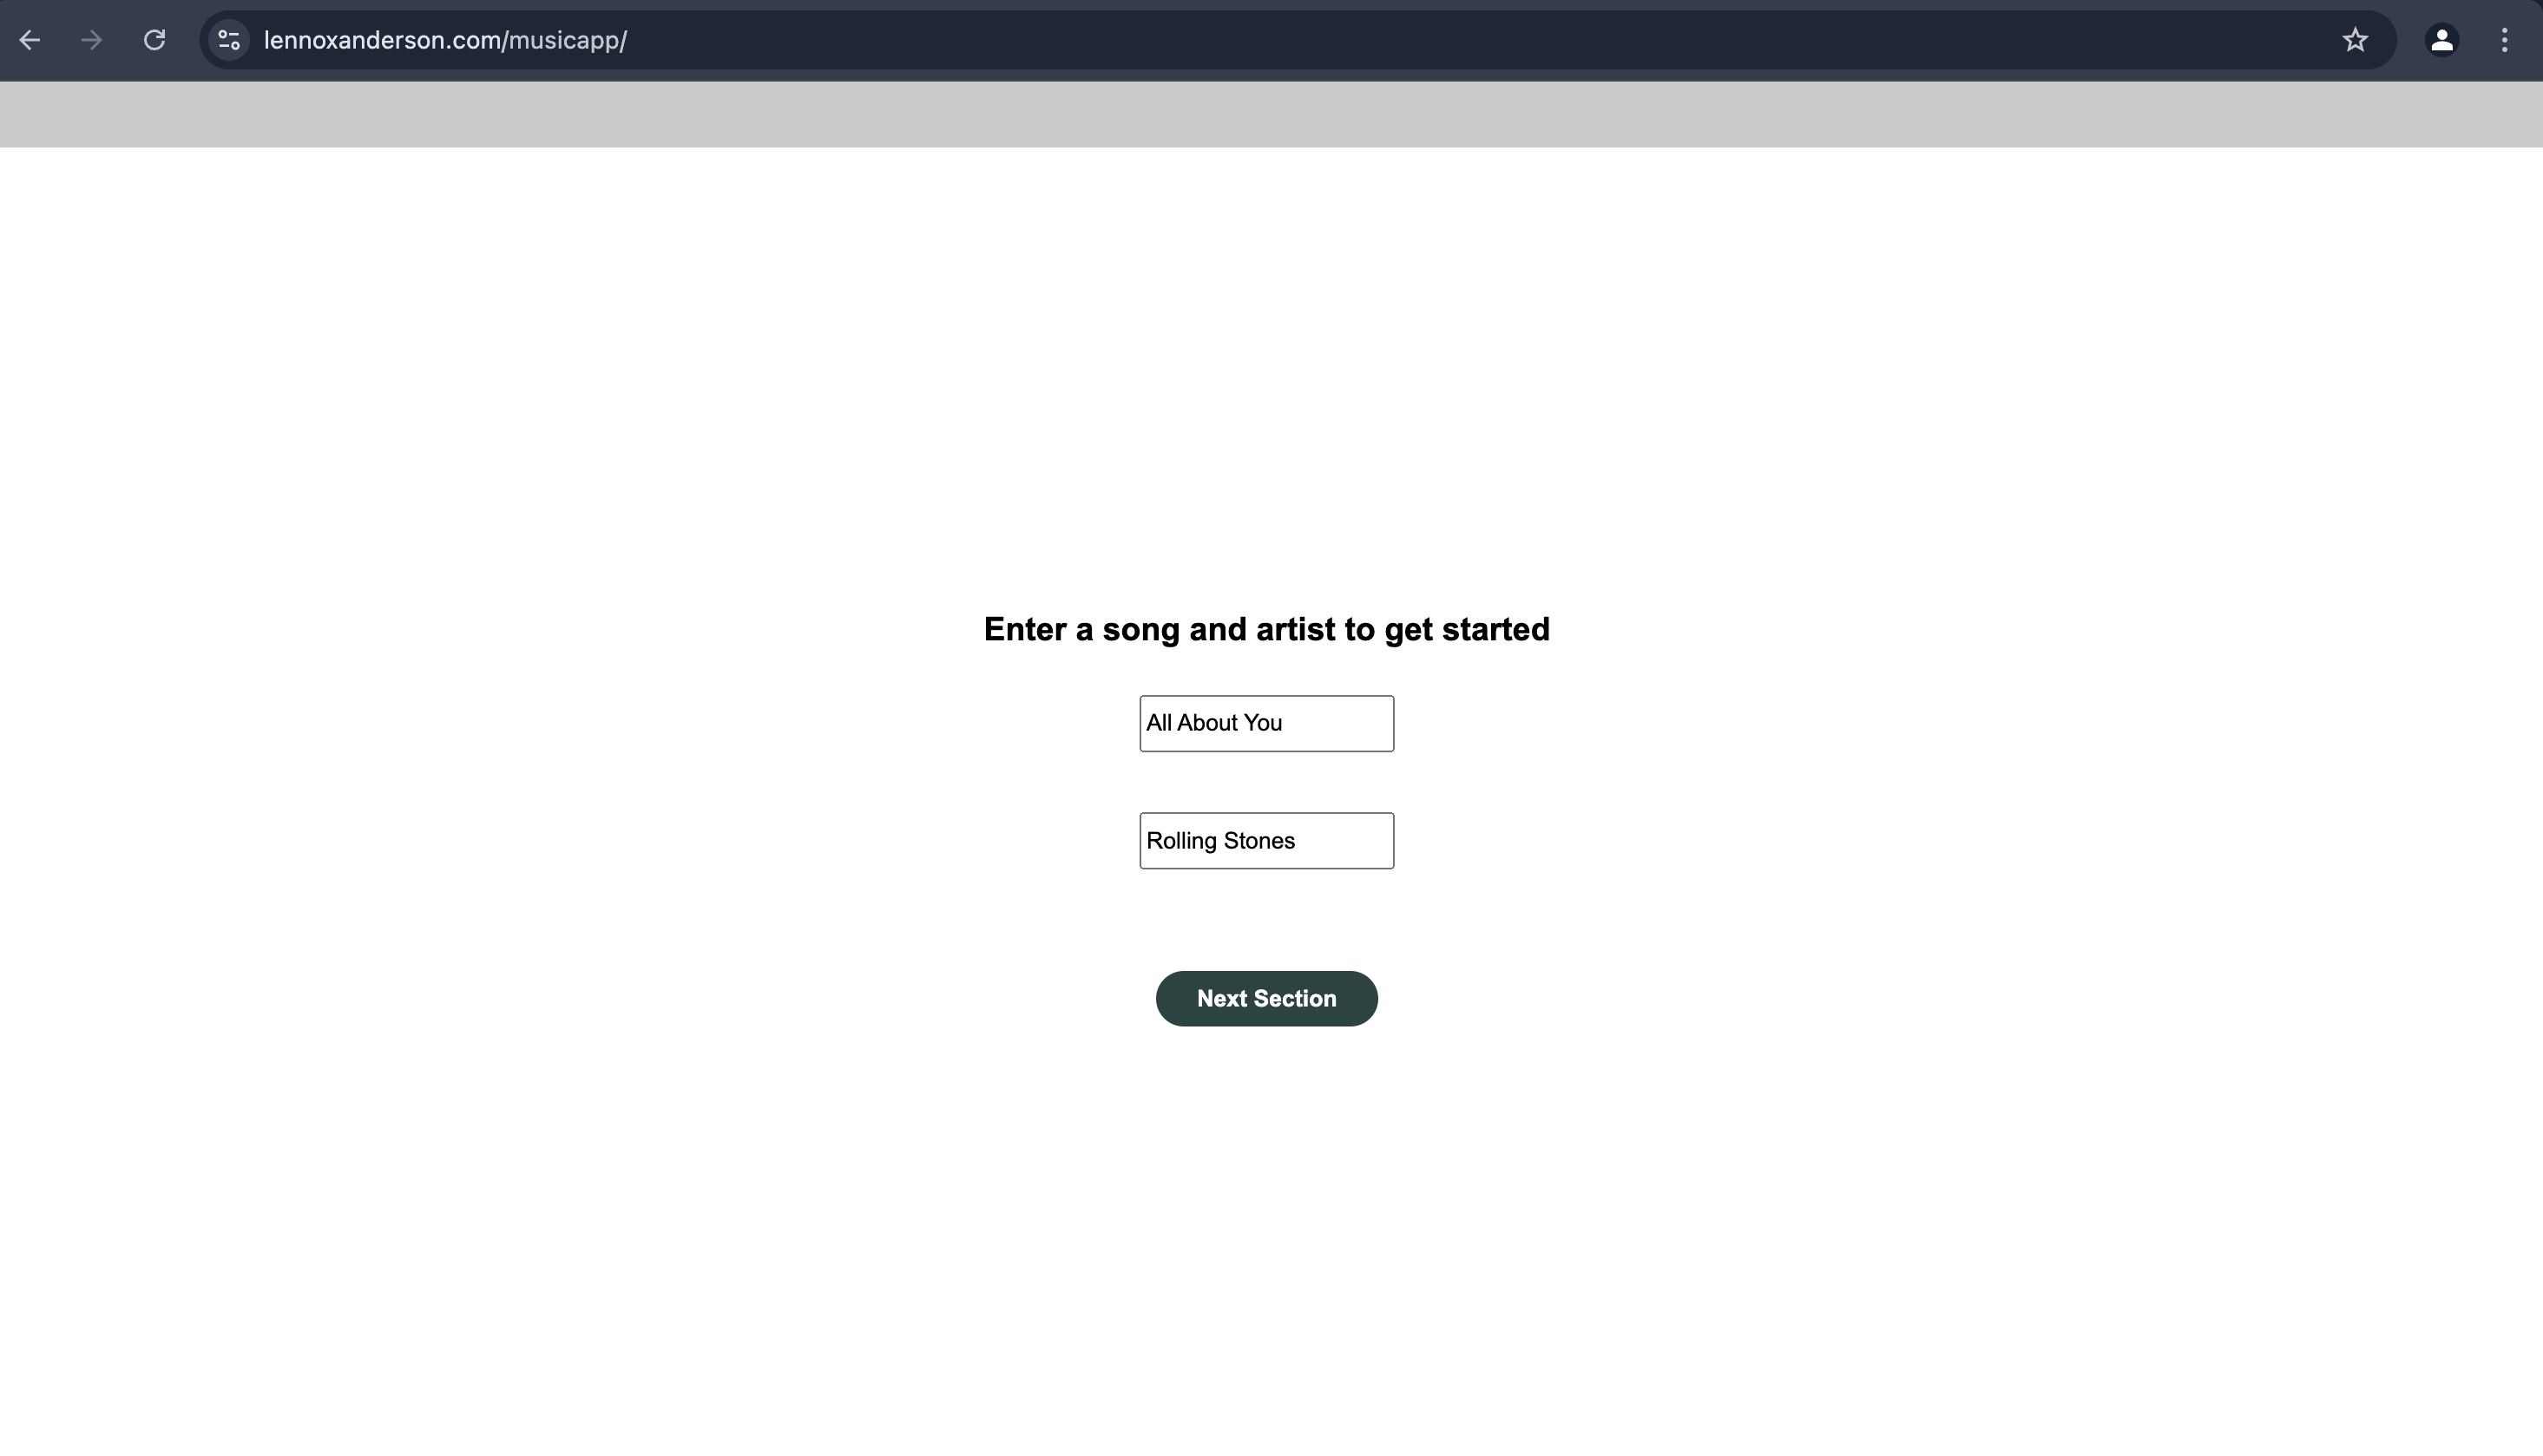

In [23]:
image_path = "/Users/lennox/Documents/machineLearning/research/modelAnalysis/page2MusicApp.png"
display(Image(filename=image_path, width=900, height=600))

### Page 3: Wait (Results should appear in ~15 seconds)

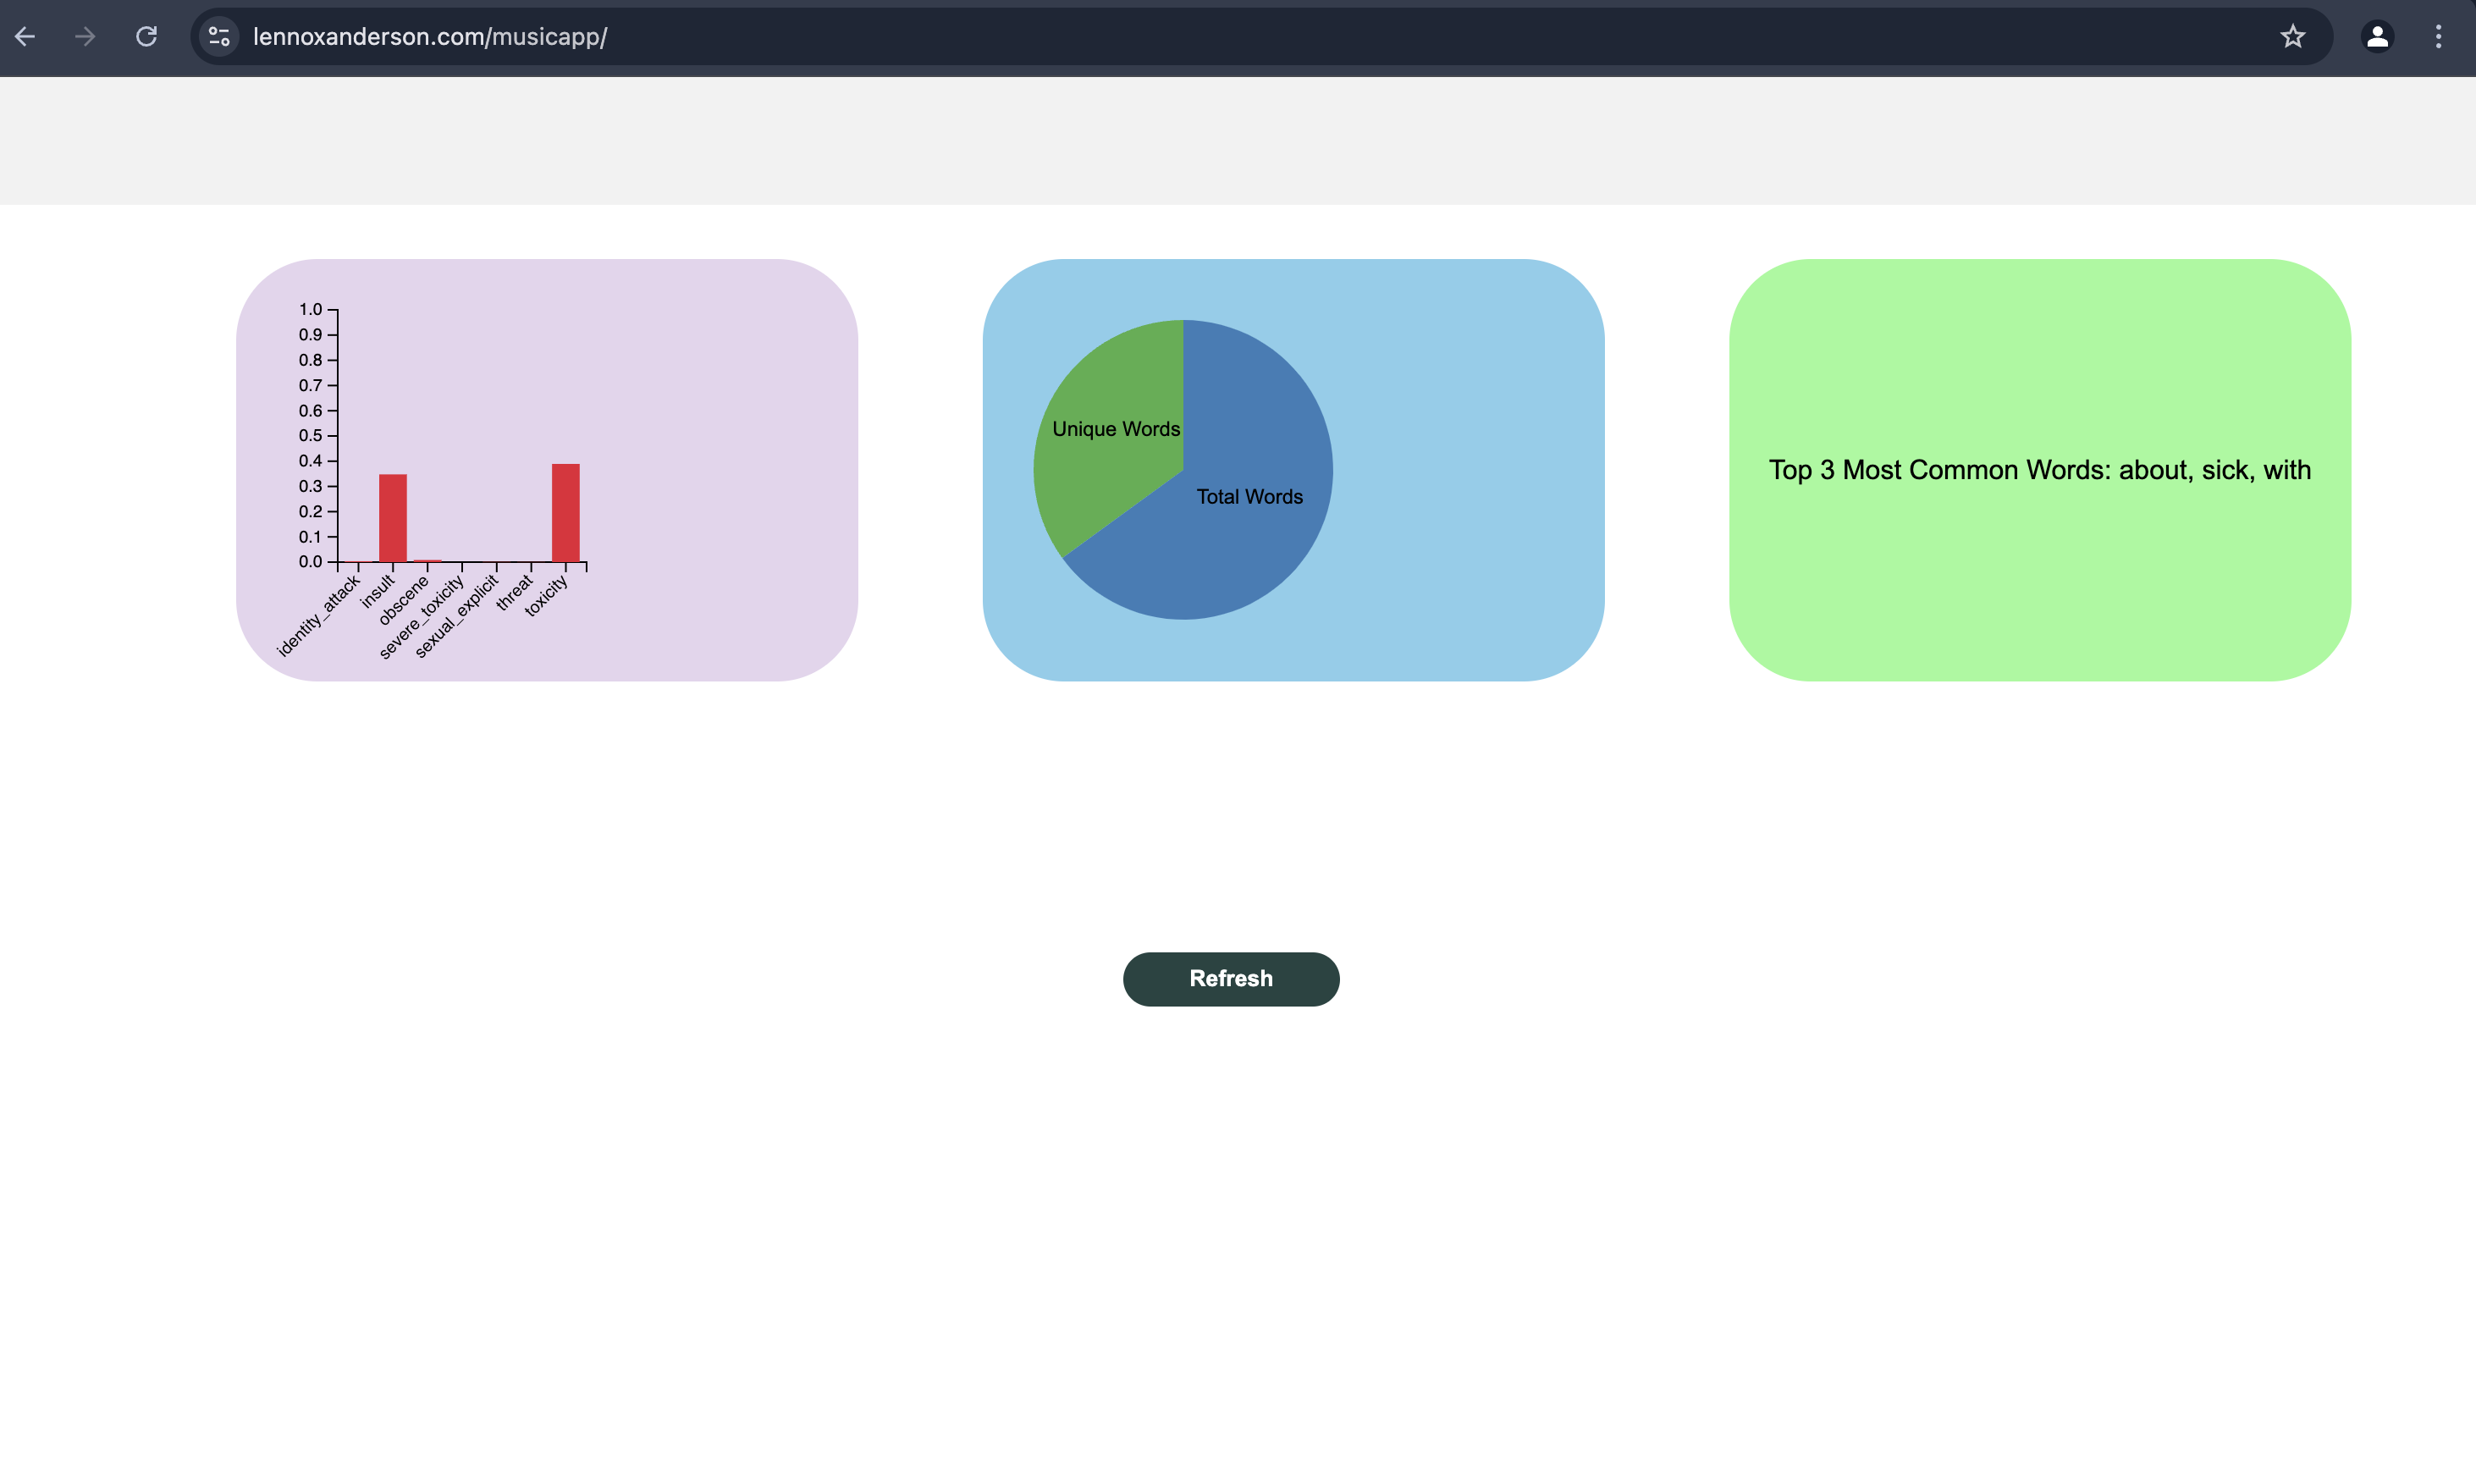

In [25]:
image_path = "/Users/lennox/Documents/machineLearning/research/modelAnalysis/page3MusicApp.png"
display(Image(filename=image_path, width=900, height=600))

The steps above demonstrate a basic analysis of a song's lyrics but don't provide insight into how the application or model arrived at the toxicity probabilities. Now, let's explore how the application can incorporate explainability using LIME to better understand the model's decision-making process.

### Explaining Toxcity Detection in the Same Model with Lime (May crash runtime if running in colab base runtime)

In [28]:
text = """
Well if you call this a life
Why must I spend it with you?
If the show must go on
Let it go on without you
So sick and tired hanging around with jerks like you
Who'll tell me those lies
And let me think they're true?
What am I to do
You want it, I got it too
Though the lies might be true
That's just cause the joke's about you
I'm so sick and tired hanging around with dogs like you
You're the first to get blamed, always the last bitch to get paid
Oh, tell me those lies
Let me think they're true
I heard one or two
They weren't about me, they weren't about her
They were all about you
I may miss you
But missing me just isn't you
I'm so sick and tired hanging around with dogs like you
Tell me those lies
Let me think they're true
I heard one or two, and they weren't about me, they weren't about her
They're all about you
I'm so sick and tired
What should I do
You want it, you get it
So how come I'm still in love with you?
"""

In [29]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from lime.lime_text import LimeTextExplainer

# Initialize BERT model for toxicity detection and tokenizing
model_name = "unitary/toxic-bert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Move model to CPU to save GPU memory (optional)
device = torch.device("cpu")  # or 'cuda' if using GPU and memory is available
model = model.to(device)
model.eval()

# BERT's labels
class_names = ['toxic', 'severe toxic', 'obscene', 'threat', 'insult', 'identity hate']

# Tokenizing text with optimizations to reduce memory usage
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256,
                   return_attention_mask=False, return_token_type_ids=False)

# Move inputs to the correct device
inputs = {key: value.to(device) for key, value in inputs.items()}

# Run inference without gradients to save memory
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

# Initialize LIME text explainer with reduced sample size for efficiency
explainer = LimeTextExplainer(class_names=class_names)

# Define prediction function for LIME, using CPU for inference
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256,
                       return_attention_mask=False, return_token_type_ids=False).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.softmax(logits, dim=-1).cpu().numpy()

# Perform LIME analysis with reduced num_samples for efficiency
explanation = explainer.explain_instance(text, predict_proba, num_features=10, num_samples=500)  # Reduced from 5000

# Show bar chart explanation in notebook
explanation.show_in_notebook(text=True)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


**Using LIME to find toxicity in music lyrics takes a long time to run, which isn't practical for web applications where users expect quick results. This slow processing makes it hard to host on platforms that require fast responses. However, LIME does offer more detailed explanations than basic analytics, helping us better understand why certain lyrics are considered toxic.)**